In [ ]:
import os
from Classes.simulation_interface import Simulation
import Classes.simulation_implementation
import utils

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import warnings
from copy import deepcopy

In [2]:
if True :
    # Create dictionary to store dataFrames for the 40 CAC40 companies
    Data10y_dic = {}

    # Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
    directory = "Data/CAC40 daily 10y"
    files = [f for f in os.listdir(directory) if 'Data' in f]
    # Process each file
    for file in files:
        # Get company name (first word before '_')
        company = file.split('_')[0]
        
        # Read the file with tab separator
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        
        # Convert first column to datetime and set as index
        df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

        df = df.drop('date', axis=1)  # Remove the original date column
        df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
        
        # Store in dictionary
        Data10y_dic[company] = df

    print(f"Loaded {len(Data10y_dic)} companies' data")

    # Create list of DataFrames with only 'clot' column
    dfs = [df['clot'] for df in Data10y_dic.values()]
    histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
    histo_CAC40 = histo_CAC40.sort_index()

    print(f"Shape of historical data: {histo_CAC40.shape}")
    print("\nFirst few rows:")
    # Drop rows with NaN values
    histo_CAC40_woNaN = histo_CAC40.dropna()
    print(f"Shape after dropping NaN rows: {histo_CAC40_woNaN.shape}")
    data = histo_CAC40_woNaN
    # Calcul du vecteur de rendement moyen annuel
    mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25
    delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
    deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
    nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
    Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
    mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

    nb_stocks = 40
    allocations_EW = np.ones(nb_stocks) / nb_stocks

# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

Loaded 40 companies' data
Shape of historical data: (2562, 40)

First few rows:
Shape after dropping NaN rows: (1733, 40)


In [3]:
nb_simu = 50
#allocation = allocations_EW
allocation = CAC40_weights

parameters_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocation,
}
simulation_BuyH = Simulation(nb_scenarios=nb_simu, model="BS", strategy="Buy and hold", parameters=parameters_BuyH)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

parameters_Rebal21 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocation,
    "Rebalancing period": 21
}
simulation_Rebal21 = Simulation(nb_scenarios=nb_simu, model="BS", strategy="Rebalancing", parameters=parameters_Rebal21)
simulation_Rebal21.scenarios = simulation_BuyH.scenarios
simulation_Rebal21.generate_evolutions()

parameters_Rebal5 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocation,
    "Rebalancing period": 5
}
simulation_Rebal5 = Simulation(nb_scenarios=nb_simu, model="BS", strategy="Rebalancing", parameters=parameters_Rebal5)
simulation_Rebal5.scenarios = simulation_BuyH.scenarios
simulation_Rebal5.generate_evolutions()

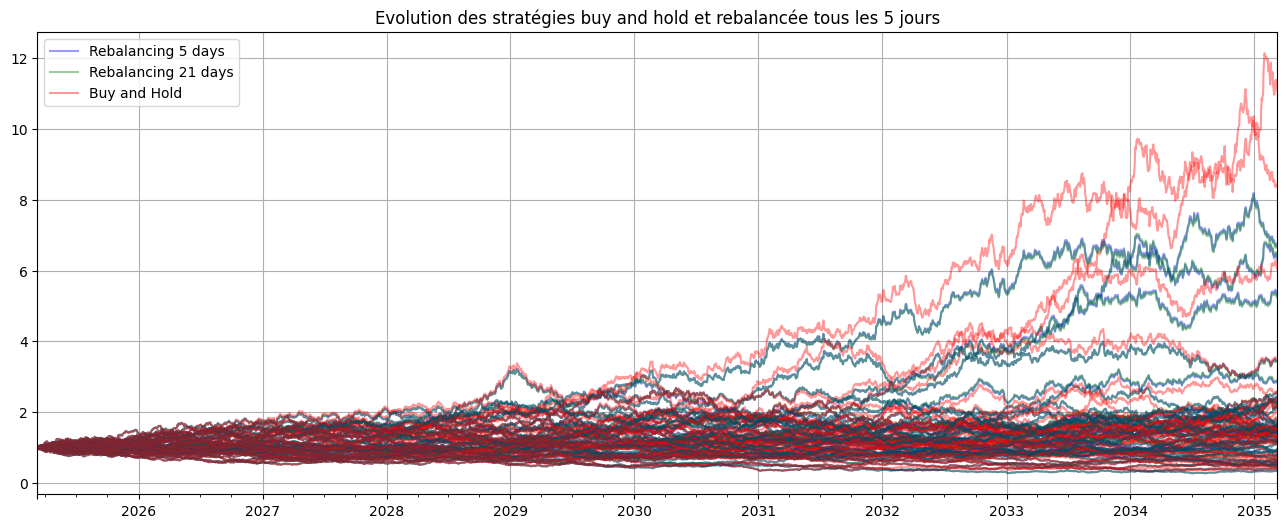

In [4]:
plt.figure(figsize=(16, 6))

lines = []
evolution_rebal5 = simulation_Rebal5.evolutions
evolution_BuyH = simulation_BuyH.evolutions
evolution_rebal21 = simulation_Rebal21.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal21[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 21 days"))
    lines.append(evolution_BuyH[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

In [5]:
Nsce = 250

In [ ]:
parameters_BuyH_sous_constrains = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation
}
Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :]).T
#string to float
Data_esg = Data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
simulation_BuyH_sous_constrains = Simulation(nb_scenarios=Nsce, model="BS", strategy="Buy and hold", parameters=parameters_BuyH_sous_constrains)
simulation_BuyH_sous_constrains.set_dataESG(Data_esg)
contraints = {
    "List" : ["Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.20, 3.5, 40, 65]
}
simulation_BuyH_sous_constrains.set_contraints(contraints)
simulation_BuyH_sous_constrains.compute_allocation()
simulation_BuyH_sous_constrains.generate_scenarios()
simulation_BuyH_sous_constrains.generate_evolutions()


# New simulation
# rebalance all 20 days and relax the constraints
parameters_BuyH_sous_constrains2 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Rebalancing period": 20
}

simulation_BuyH_sous_constrains2 = deepcopy(simulation_BuyH_sous_constrains)
simulation_BuyH_sous_constrains2.set_parameters(parameters_BuyH_sous_constrains2)
contraints2 = {
    "List" : ["Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.25, 7, 2000, 50]
}
simulation_BuyH_sous_constrains2.set_contraints(contraints2)
simulation_BuyH_sous_constrains2.compute_allocation()
simulation_BuyH_sous_constrains2.generate_evolutions()

AttributeError: 'Simulation' object has no attribute 'copy'

In [7]:
#print vol et rendement allocation
allocation = simulation_BuyH_sous_constrains.parameters["Allocation"]
returns = parameters_BuyH_sous_constrains["Returns"]
volatilities = parameters_BuyH_sous_constrains["Volatilities"]
Correlation_matrix = parameters_BuyH_sous_constrains["Correlation matrix"]
covMatrix = np.diag(volatilities) @ Correlation_matrix @ np.diag(volatilities)
portfolio_return = allocation @ returns
portfolio_variance = allocation @ covMatrix @ allocation
portfolio_Carbon_risk = allocation @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity = allocation @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management = allocation @ Data_esg["Score management"]

print("Portfolio 1:")
print(f"Portfolio return : {portfolio_return}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity}")
print(f"Portfolio Score management: {portfolio_score_management}")


#print vol et rendement allocation
allocation2 = simulation_BuyH_sous_constrains2.parameters["Allocation"]
portfolio_return2 = allocation2 @ returns
portfolio_variance2 = allocation2 @ covMatrix @ allocation2
portfolio_Carbon_risk2 = allocation2 @ Data_esg["Carbon risk"]
portfolio_Carbon_intensity2 = allocation2 @ Data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management2 = allocation2 @ Data_esg["Score management"]
print("\nPortfolio 2:")
print(f"Portfolio return: {portfolio_return2}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance2)}")
print(f"Portfolio Carbon risk: {portfolio_Carbon_risk2}")
print(f"Portfolio Carbon intensity: {portfolio_Carbon_intensity2}")
print(f"Portfolio Score management: {portfolio_score_management2}")

Portfolio 1:
Portfolio return : 0.2057332114479297
Portfolio volatility: 0.25000000000679423
Portfolio Carbon risk: 1.4856156095476294
Portfolio Carbon intensity: 4.166176850019991
Portfolio Score management: 65.07799117090094

Portfolio 2:
Portfolio return: 0.2057332114479297
Portfolio volatility: 0.25000000000679423
Portfolio Carbon risk: 1.4856156095476294
Portfolio Carbon intensity: 4.166176850019991
Portfolio Score management: 65.07799117090094


In [8]:
simulation_BuyH_sous_constrains.compute_metrics()
print(simulation_BuyH_sous_constrains.metrics)
print("\n")
simulation_BuyH_sous_constrains2.compute_metrics()
print(simulation_BuyH_sous_constrains2.metrics)

{'Mean terminal value': 1.411413968512742, 'Median terminal value': 1.0376263445113167, 'Volatility of terminal value': 1.262440103826027, 'VaR(95.0%)': 0.26371840932795854, 'CVaR(95.0%)': 0.1989348301061775}


{'Mean terminal value': 1.411413968512742, 'Median terminal value': 1.0376263445113167, 'Volatility of terminal value': 1.262440103826027, 'VaR(95.0%)': 0.26371840932795854, 'CVaR(95.0%)': 0.1989348301061775}


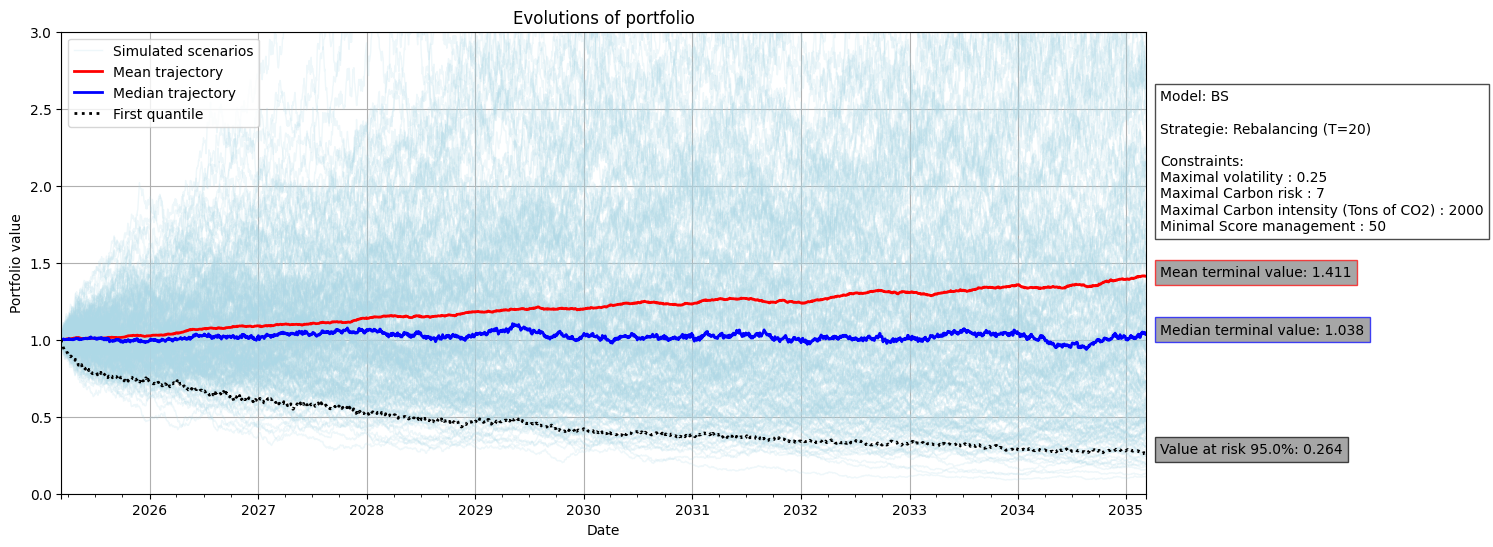

In [9]:
simulation_BuyH_sous_constrains.plot()

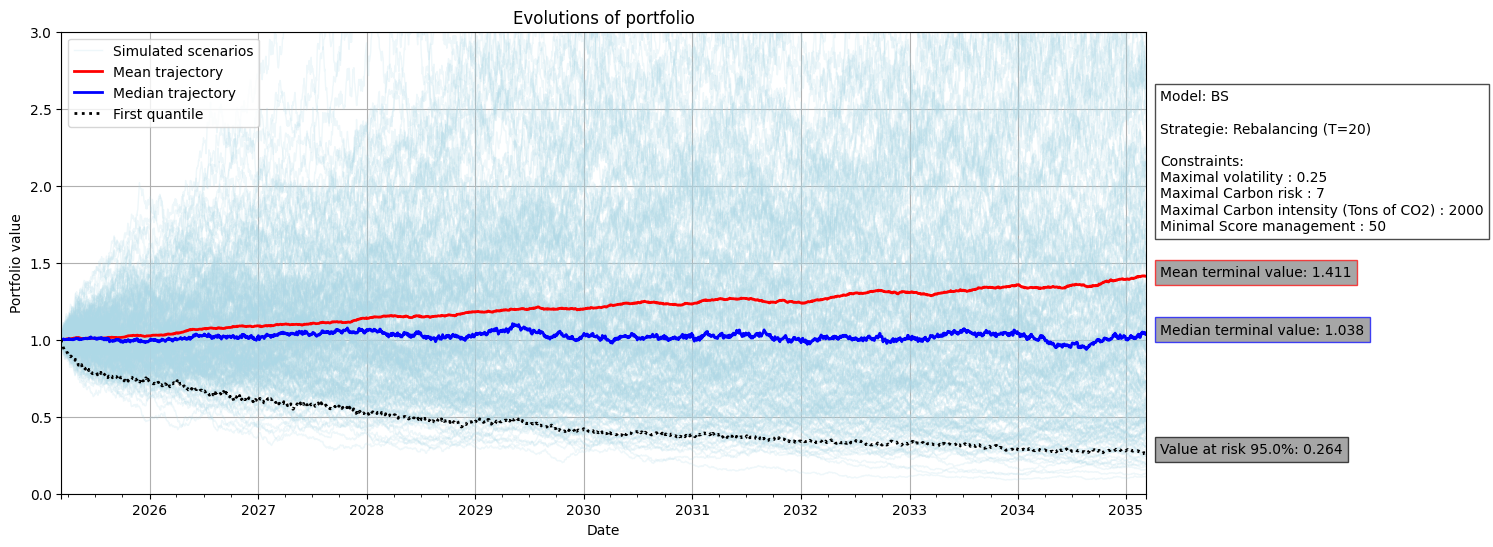

In [10]:
simulation_BuyH_sous_constrains2.plot()